### Exploratory Data Analysis

In [3]:
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import import_ipynb
import data_acquisition
import feature_engineering

#### 1. Reading Data

In [5]:
# fetch data objects using defined functions
ratings, business, checkin, user, tips = feature_engineering.get_yelp_data()

100%|██████████| 1223094/1223094 [00:07<00:00, 174095.68it/s]


#### 2. Frequency Distribution of Review Count

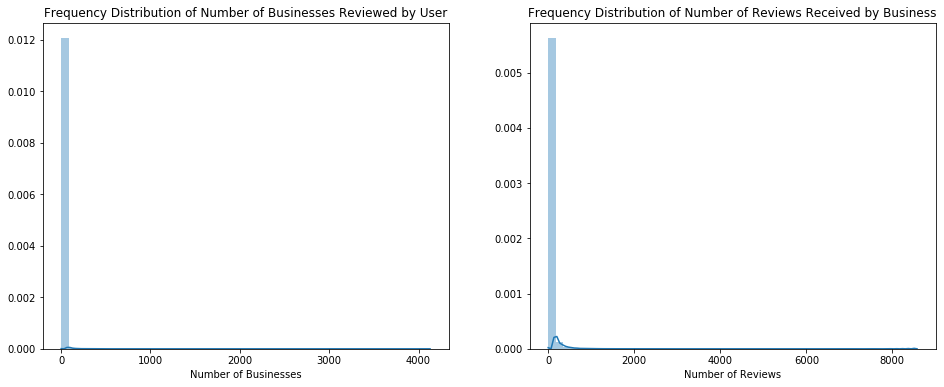

In [42]:
f, (ax1, ax2) = plt.subplots(figsize = (16, 6), ncols = 2)

# frequency distribution of number of businesses reviewed by each user 
user_cnt_business_reviewed = ratings.groupby(['user_id']).count()['review_id']
sns.distplot(user_cnt_business_reviewed, ax = ax1)
ax1.set_title('Frequency Distribution of Number of Businesses Reviewed by User')
ax1.set_xlabel('Number of Businesses')

# frequency distribution of number of reviews received by each business
business_cnt_reviewed = ratings.groupby(['business_id']).count()['review_id']

sns.distplot(business_cnt_reviewed, ax = ax2)
ax2.set_title('Frequency Distribution of Number of Reviews Received by Business')
ax2.set_xlabel('Number of Reviews')
plt.show()

Looking at the frequency distribution of our data, both from user and business perspective, we see that majority of users have reviewed very few businesses and likewise majority of businesses have received very few reviews. The user-business interactions are not dense, and we would like to consider only active users and active businesses for our model in order to eliminate noise.

In [44]:
print('Number of Unique Users :', user_cnt_business_reviewed.shape[0])
print('Number of Unique Businesses :', business_cnt_reviewed.shape[0])

print('\nNumber of Businesses Reviewed by User')
print('Mean =', np.round(np.mean(user_cnt_business_reviewed), 2))
print('Median =', np.round(np.median(user_cnt_business_reviewed), 2))

print('\nNumber of Reviews Received by Business')
print('Mean =', np.round(np.mean(business_cnt_reviewed), 2))
print('Median =', np.round(np.median(business_cnt_reviewed), 2))

Number of Unique Users : 1637138
Number of Unique Businesses : 192606

Number of Businesses Reviewed by User
Mean = 4.08
Median = 1.0

Number of Reviews Received by Business
Mean = 34.71
Median = 9.0


#### 3. Frequency Distribution of Average Rating of Each User

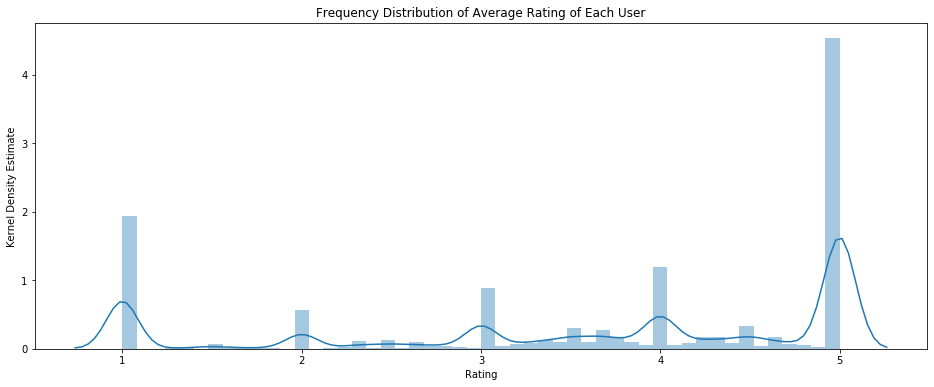

In [64]:
# frequency distribition of average rating given by a user
user_avg_rating = ratings.groupby('user_id')['rating'].mean()

f, (ax1) = plt.subplots(figsize = (16, 6), ncols = 1)
sns.distplot(user_avg_rating, ax = ax1)
ax1.set_title('Frequency Distribution of Average Rating of Each User')
ax1.set_ylabel('Kernel Density Estimate')
ax1.set_xlabel('Rating')
plt.show()

In [65]:
print('Ratings Provided by Users')
print('Mean =', np.round(np.mean(user_avg_rating), 2))
print('Median =', np.round(np.median(user_avg_rating), 2))

Ratings Provided by Users
Mean = 3.64
Median = 4.0


The above results were contradictory to our expectation. We assumed that users in general take the effort to provide a review mostly when they have had a negative experience. And even though there are significant number of users with their average rating across businesses equal to 1, the majority of users have their average rating greater than 4. As the perception of good and bad in terms of 1-5 scale differs from person to person, user bias is an important feature.

#### 4. Total Reviews Each Year

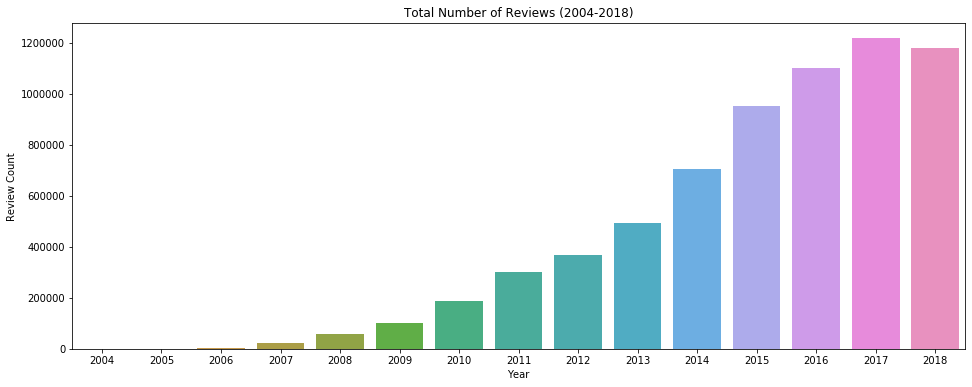

In [66]:
# total number of reviews received each year
ratings['year'] = pd.DatetimeIndex(ratings['date']).year
review_cnt = pd.DataFrame(ratings.groupby('year')['review_id'].count()).reset_index()

f, (ax) = plt.subplots(figsize = (16, 6), ncols = 1)
ax = sns.barplot(x = "year", y = "review_id", data = review_cnt)
ax.set_title('Total Number of Reviews (2004-2018)')
ax.set_xlabel('Year')
ax.set_ylabel('Review Count')
plt.show()

Over the last 14 years, the number of reviews that were posted on Yelp kept increasing before it dipped marginally in 2018. It is safe to assume that user preferences change over time and even the performance of a business can change considerably. As our end outcome is to provide recommendations, it should reflect the current state of a business, and align and learn from current taste of similar users. Moreover, as we are looking to train our model on a smaller subset of data, it is logical to consider recent data for analysis. We will subsequently add previous years data to analyze how well our model scales.

#### 5. Total Reviews by Business City

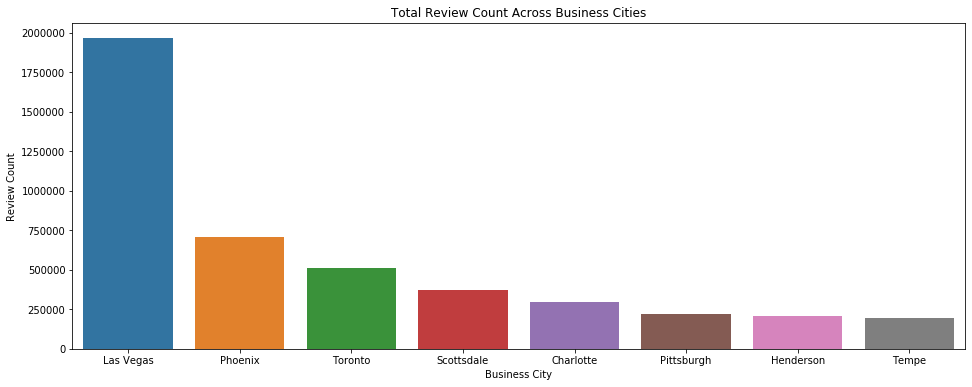

In [81]:
# total number of reviews received each year
total_review_cnt = np.round(np.sum(business['review_count']), 1)
city_business_cnt = pd.DataFrame(business.groupby('city')['review_count'].sum()).reset_index()
city_business_cnt = city_business_cnt.sort_values(by = 'review_count', ascending = False).head(8)

f, (ax) = plt.subplots(figsize = (16, 6), ncols = 1)
ax = sns.barplot(x = "city", y = "review_count", data = city_business_cnt)
ax.set_title('Total Review Count Across Business Cities')
ax.set_xlabel('Business City')
ax.set_ylabel('Review Count')
plt.show()

In [82]:
coverage = np.round((city_business_cnt.iloc[0,1]/total_review_cnt)*100,1)
print(str(city_business_cnt.iloc[0,0]) + ' covers ' + str(coverage) + "% of total reviews")

Las Vegas covers 30.4% of total reviews


In term of total review count, the businesses situated in Las Vegas have received more reviews than businesses in any other city. Las Vegas covers 30.4% of total reviews in our data. As users’ spending capacity, preferences and type of businesses vary from city to city, we will subset our data to only include reviews attributed to businesses from Las Vegas. At this stage, this project is not focused on building a location-aware recommendation system and in order to ensure that our business recommendations are relevant to users, in terms of proximity, we need to filter our data for Las Vegas.